In [ ]:
# https://vitalab.github.io/article/2017/08/22/deep-watershed.html
# https://www.kaggle.com/code/yl148yl148/unet-with-deep-watershed-transform-dwt-train/edit
# https://colab.research.google.com/drive/19_lXGRo35WEqxlbvpr7o6-XXtX1NBnWx#scrollTo=LDjuVFgexFfh


# Watershed

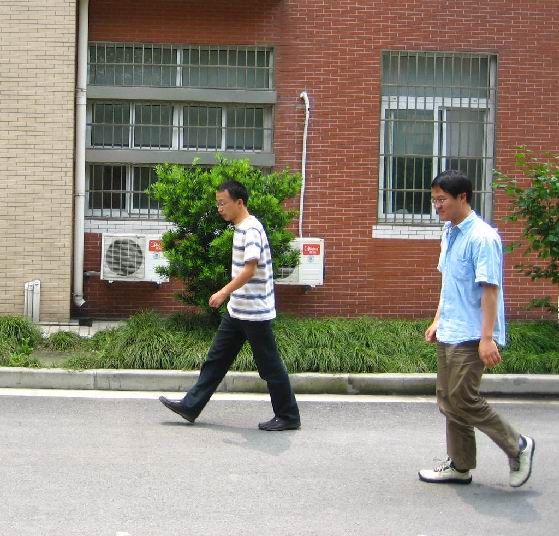

In [236]:
from PIL import Image
import glob
from skimage import measure, color
import os
import cv2
import math
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score
import random

from PIL import Image, ImageOps
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import models
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import sys

    
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

In [95]:
# watershed

(536, 559)
{0, 1, 2}


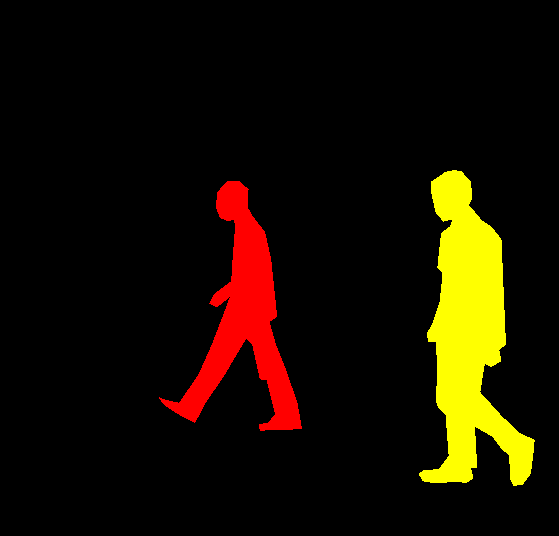

In [96]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask_array = np.array(mask)
print(mask_array.shape)
print(set(mask_array.reshape(-1)))
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])

mask


In [97]:
print(set(np.array(mask).reshape(-1)))

{0, 1, 2}


In [98]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084d version check against PyTorch's CUDA version


In [181]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((576, 576), resample=Image.BILINEAR)
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        mask = mask.resize((576, 576), resample=Image.BILINEAR)
        mask = np.array(mask)
        binary_mask = (mask > 0).astype(int)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        binary_mask = torch.as_tensor(binary_mask, dtype=torch.long).unsqueeze(0)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target['binary_mask'] = binary_mask
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [182]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=576x576 at 0x7EFEA1EDE760>,
 {'boxes': tensor([[164., 182., 551., 522.],
          [432., 183., 550., 521.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'binary_mask': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]]),
  'image_id': tensor([0]),
  'area': tensor([131580.,  3

In [183]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [185]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
def collate_fn_instance(batch):
#     print([img for img, _ in batch])
#     sys.exit()
    return torch.stack([img for img, _ in batch]), torch.stack([tgt['binary_mask'] for _, tgt in batch])
#     return tuple(zip(*batch))
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn_instance)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=0,
    collate_fn=collate_fn_instance)
for data in data_loader:
#     print(data[0].shape, data[1].shape)
    pass

In [160]:
# https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-easy-way-62631c7fa8f6
class DoubleConv(nn.Module):
    # The double convolution modules
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel size 3, padding 1
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            # Set the bias to false since bias is going to be offset by BatchNorm2d
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UpPool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpPool, self).__init__()
        self.tranconv = nn.Sequential (
            nn.ConvTranspose2d(
                    in_channels, out_channels, kernel_size=2, stride=2,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.tranconv(x)
    
    
class ResnetBasedModel(nn.Module):
    
    def __init__(self, pretrained_resnet, num_layers_to_remove=4):
        super(ResnetBasedModel, self).__init__()
        # You can, for example, extract the first N layers of the model like this:
        # self.resnet_features = nn.Sequential(*list(pretrained_resnet.children())[:N])
        # 10 layers in total and the first 8 layers are for feature extraction 
        self.resnet_features = nn.Sequential(*list(pretrained_resnet.children())[:-num_layers_to_remove])
        self.decoder = nn.ModuleList()
        
        for param in self.resnet_features.parameters():
             param.requires_grad = False

        
        
        dims =[64, 128]
#         dims =[16, 32, 64, 128]
        
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down-sampling
        self.downs.append(DoubleConv(128, dims[0]))
        for i in range(1, len(dims)):
            self.downs.append(DoubleConv(dims[i-1], dims[i]))

        # upsampling
        for dim in reversed(dims):
            self.ups.append(
                UpPool(dim*2, dim)
                #                 nn.ConvTranspose2d(
#                     dim*2, dim, kernel_size=2, stride=2,
#                 )
            )
            self.ups.append(DoubleConv(dim*2, dim))

        self.bottleneck = DoubleConv(dims[-1], dims[-1]*2)
        
        self.upsamples = nn.ModuleList()
        self.upsamples.append(
            UpPool(64, 64)
        )
        self.upsamples.append(
            UpPool(64, 32)
        )

        self.upsamples.append(
            UpPool(32, 16)
        )
        self.final_conv = DoubleConv(16, 2)

        
    def forward(self, x):
        skip_connections = []

        original_size = x.shape
        x = self.resnet_features(x)
        
        for idx, down in enumerate(self.downs):
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottleneck(x)
#         print('after bpttleneck', x.shape)
        skip_connections.reverse()
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        for upsample in self.upsamples:
            x = upsample(x)
        x = self.final_conv(x)
        return x


In [197]:
def segmentation_eval(gts, preds, classes, plot_file_name):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    @param    plot_file_name    string          plot file names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    plot_results(counts, ious, aps, classes, plot_file_name)
    for i in range(2):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious

def plot_results(counts, ious, aps, classes, file_name):
    fig, ax = plt.subplots(1,1)
    conf = counts / np.sum(counts, 1, keepdims=True)
    conf = np.concatenate([conf, np.array(aps).reshape(-1,1), 
                           np.array(ious).reshape(-1,1)], 1)
    conf = conf * 100.
    sns.heatmap(conf, annot=True, ax=ax, fmt='3.0f') 
    arts = [] 
    # labels, title and ticks
    _ = ax.set_xlabel('Predicted labels')
    arts.append(_)
    _ = ax.set_ylabel('True labels')
    arts.append(_)
    _ = ax.set_title('Confusion Matrix, mAP: {:5.1f}, mIoU: {:5.1f}'.format(
      np.mean(aps)*100., np.mean(ious)*100.))
    arts.append(_)
    _ = ax.xaxis.set_ticklabels(classes + ['AP', 'IoU'], rotation=90)
    arts.append(_)
    _ = ax.yaxis.set_ticklabels(classes, rotation=0)
    arts.append(_)
    # fig.savefig(file_name, bbox_inches='tight')
    plt.show()

def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
        ap, prec, rec = calc_pr(gts == i, preds[:,i:i+1,:,:])
        aps.append(ap)
    return aps

def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1,1))
    out = out.astype(np.float64).reshape((-1,1))
    tog = np.concatenate([gt, out], axis=1)*1.
    ind = np.argsort(tog[:,1], axis=0)[::-1]
    tog = tog[ind,:]
    cumsumsortgt = np.cumsum(tog[:,0])
    cumsumsortwt = np.cumsum(tog[:,0]-tog[:,0]+1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:,0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec

def voc_ap(rec, prec):
    rec = rec.reshape((-1,1))
    prec = prec.reshape((-1,1))
    z = np.zeros((1,1)) 
    o = np.ones((1,1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0]+1;
    ap = np.sum((mrec[I] - mrec[I-1])*mpre[I])
    return ap
    
# Question 3: compute the confusion matrix and IoU metrics
# Hint: once you've computed the confusion matrix, IoU is easy
# Note: preds contains class probabilities, convert this to a class prediction
def compute_confusion_matrix(gts, preds):
    # Your code
    IoU = np.zeros((2))
    conf = np.zeros((2, 2))
#     print(gts.shape, preds.shape)
#     N = gts.shape[0] * gts.shape[1] * gts.shape[2]
#     print(type(gts))
#     print('gts.shape', gts.shape)
    
#     gts = np.transpose(gts, (0,3, 2, 1))
#     preds = np.transpose(preds, (0,3, 2, 1))
    preds = np.argmax(preds, axis=1)
    for gt, pred in zip(gts.reshape(-1).astype(int), preds.reshape(-1)):
#         print(gt)
        conf[gt][pred]+=1
    for i in range(9):
        IoU[i] = conf[i][i] / (sum(conf[i]) + sum(conf[:,i]) - conf[i][i])
    return IoU, conf




def validate_model(val_loader, model, classes, device, show_matrix=False):
    preds = np.array([]).reshape(0,2,576,576)
    gts = np.array([]).reshape(0,1,576,576)
    with torch.no_grad():
        print('Outside loop')
        for idx, data in enumerate(val_loader):
            print(idx, 'val')
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            preds = np.concatenate([preds, outputs], axis=0)
            gts = np.concatenate([gts, labels.numpy()], axis=0)
            
            print("Validating...{}\r".format(100.0*len(preds)/len(val_loader)), end="")
    
    if show_matrix:
        aps, ious = segmentation_eval(gts, preds, classes, 'bonus.pdf')
    else:
        ious, counts = compute_confusion_matrix(gts, preds)
        aps = compute_ap(gts, preds)
        for i in range(len(classes)):
            print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))

    return preds, gts

# Your goal is to complete this function
def train(model, optimizer, criterion, trainloader, device, valloader = None, epochs=15):
    import copy
    train_loss_over_epochs = []
    val_loss_over_epochs = []
    plt.ioff()
    fig = plt.figure()
    best_loss = None
    best_model = copy.deepcopy(model)
    try:
        for epoch in range(epochs):
            # running loss is the **average** loss for each item in the dataset during this epoch
            running_loss = 0.0

            for i, data in enumerate(trainloader, 0):
                # Your code
                # -------------------------
                inputs, labels = data
    #             print(type(labels))
                inputs = inputs.to(device)
                outputs = model(inputs).cpu()
#                 loss =  cross_entropy_criterion(outputs, labels)
                loss =  criterion(outputs, labels)
                running_loss+= loss.item()
                ## backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # -------------------------
            running_loss /= len(trainloader)
            if valloader is None:
                if best_loss is None or running_loss < best_loss:
                    best_loss, best_model =running_loss, copy.deepcopy(model)
                
            train_loss_over_epochs.append(running_loss)
            # Note: it can be more readable to overwrite the previous line - end="\r"
            print('Epoch: {}, training loss: {:.3f}'.format(epoch + 1, running_loss))


            # If you pass in a validation dataloader then compute the validation loss
            if not valloader is None:
                val_loss = 0.0
                with torch.no_grad():
                    for data in valloader:
                        # Your code
                        # -------------------------
                        inputs, labels = data
                        inputs = inputs.to(device)
                        outputs = model(inputs).cpu()
                        loss =  criterion(outputs, labels)
#                         loss =  cross_entropy_criterion(outputs, labels)
                        val_loss+= loss.item()
                    val_loss /= len(valloader)
                        # -------------------------
                val_loss_over_epochs.append(val_loss)
                if best_loss is None or val_loss < best_loss:
                    best_loss, best_model = val_loss, copy.deepcopy(model)
                print('Epoch: {}, validation loss: {:.3f}'.format(epoch + 1, val_loss))
    except KeyboardInterrupt:
        print('Finished', epoch+1 , 'epochs')
    except:
        import traceback
        traceback.print_exc()
            
    plt.subplot(2, 1, 1)
    plt.ylabel('Loss')
    plt.plot(np.arange(len(train_loss_over_epochs)), train_loss_over_epochs, color='red', label='train')
    print(not valloader is None)
    if not valloader is None:
        plt.plot(np.arange(len(val_loss_over_epochs)), val_loss_over_epochs, color='blue', label='val')
    plt.title('Loss per Epoch')
#     plt.xticks(np.arange(epochs, dtype=int))
    plt.xticks(np.arange(len(train_loss_over_epochs), dtype=int))
    plt.grid(True)
    plt.legend()
    plt.show()
#     return model
    return best_model



In [192]:
pretrained_resnet = models.resnet18(pretrained=True)
# print(pretrained_resnet)
print(len(list(pretrained_resnet.children())))
resnet_based_model = ResnetBasedModel(pretrained_resnet).to(device)

10


Using device: cuda:0
Epoch: 1, training loss: 0.520
Epoch: 1, validation loss: 0.475
Epoch: 2, training loss: 0.513
Epoch: 2, validation loss: 0.467
Epoch: 3, training loss: 0.505
Epoch: 3, validation loss: 0.466
Epoch: 4, training loss: 0.494
Epoch: 4, validation loss: 0.458
Epoch: 5, training loss: 0.483
Epoch: 5, validation loss: 0.441
Epoch: 6, training loss: 0.492
Epoch: 6, validation loss: 0.461
Epoch: 7, training loss: 0.482
Epoch: 7, validation loss: 0.450
Epoch: 8, training loss: 0.463
Epoch: 8, validation loss: 0.424
Epoch: 9, training loss: 0.470
Epoch: 9, validation loss: 0.426
Epoch: 10, training loss: 0.466
Epoch: 10, validation loss: 0.426
Epoch: 11, training loss: 0.461
Epoch: 11, validation loss: 0.445
Epoch: 12, training loss: 0.456
Epoch: 12, validation loss: 0.423
Epoch: 13, training loss: 0.446
Epoch: 13, validation loss: 0.421
Epoch: 14, training loss: 0.460
Epoch: 14, validation loss: 0.422
Epoch: 15, training loss: 0.443
Epoch: 15, validation loss: 0.399
Epoch: 

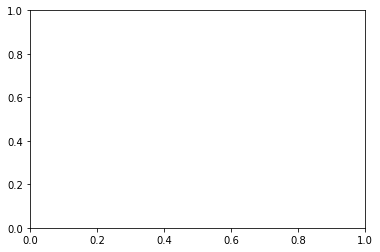

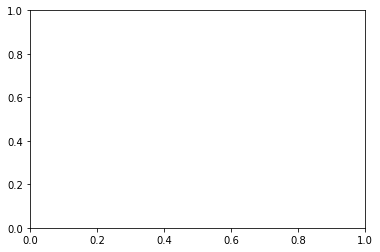

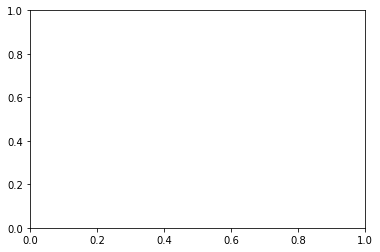

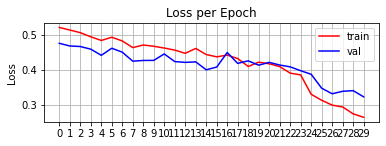

Outside loop
0 val
1 valating...8.0
2 valating...16.0
3 valating...24.0
4 valating...32.0
5 valating...40.0
6 valating...48.0
7 valating...56.0
8 valating...64.0
9 valating...72.0
10 valting...80.0
11 valting...88.0
12 valting...96.0
13 valting...104.0
14 valting...112.0
15 valting...120.0
16 valting...128.0
17 valting...136.0
18 valting...144.0
19 valting...152.0
20 valting...160.0
21 valting...168.0
22 valting...176.0
23 valting...184.0
24 valting...192.0


<ipython-input-197-e367406c3b7a>:91: RuntimeWarning: invalid value encountered in double_scalars
  IoU[i] = conf[i][i] / (sum(conf[i]) + sum(conf[:,i]) - conf[i][i])
<ipython-input-197-e367406c3b7a>:18: RuntimeWarning: invalid value encountered in true_divide
  conf = counts / np.sum(counts, 1, keepdims=True)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 9 and the array at index 1 has size 2

In [200]:
%%time

# if runtime has GPU use GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device:", device)

def cross_entropy_criterion(predictions, labels, weights = torch.ones(9)):   
    predictions = F.log_softmax(predictions, dim=1)
    weights = weights[labels]
    loss = - weights * predictions.gather(index=labels, dim=1)
    
    loss /= weights.sum()

    return loss.sum()

criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true)

optimizer = optim.Adam(resnet_based_model.parameters(), lr=0.0005)

resnet_based_model = train(resnet_based_model, optimizer, criterion, data_loader, device, data_loader_test,epochs=70)
# preds, gts = validate_model(data_loader_test, resnet_based_model, [0,1], device, True)

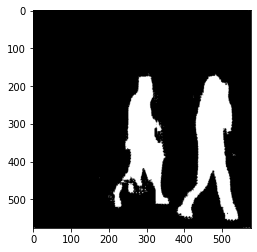

In [209]:
for data in data_loader:
    segmented = resnet_based_model(data[0].to(device)).cpu().detach().numpy()
    break
segmented = np.argmax(segmented[0], axis=0)
plt.imshow(segmented, cmap='gray')

plt.show()


In [215]:
plt.imsave('gray/example-segmentation.jpg', segmented, cmap='gray')

In [217]:
img = cv2.imread('gray/example-segmentation.jpg')  #Read as color (3 channels)
img_grey = img[:,:,0]
ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [218]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

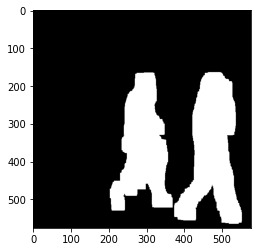

In [219]:
sure_bg = cv2.dilate(opening,kernel,iterations=10)
plt.imshow(sure_bg, cmap='gray')

plt.show()

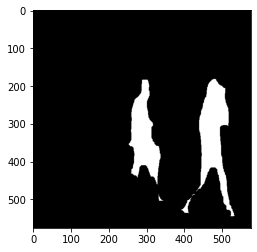

In [221]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(),255,0)
plt.imshow(sure_fg, cmap='gray')

plt.show()

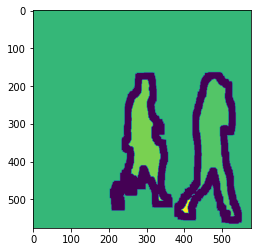

In [231]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret3, markers = cv2.connectedComponents(sure_fg.astype(np.uint8))
markers = markers+10

markers[unknown==255] = 0
plt.imshow(markers)


In [238]:
markers = cv2.watershed(img, markers)


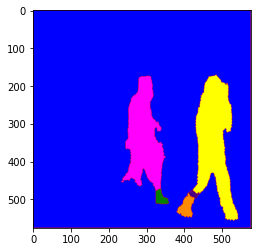

In [252]:
img[markers == -1] = [0,255,255]  
img2 = color.label2rgb(markers, bg_label=0)
plt.imshow(img)
plt.imshow(img2)
plt.imsave('seg/example.png', img2, cmap='gray')

In [253]:
for _ in data_loader:
    pass
!mkdir gray
!mkdir seg
def inst_seg_image(segmented, name):
    plt.imsave('gray/'+name+'.png', segmented, cmap='gray')
    img = cv2.imread('gray/'+name+'png')  #Read as color (3 channels)
    img_grey = img[:,:,0]
    ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=10)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    ret3, markers = cv2.connectedComponents(sure_fg.astype(np.uint8))
    markers = markers+10

    markers[unknown==255] = 0
    img[markers == -1] = [0,255,255]  
    img2 = color.label2rgb(markers, bg_label=0)
    plt.imshow(img)
    plt.imshow(img2)
    plt.imsave('seg/'+name+'.png', img2, cmap='gray')

mkdir: cannot create directory ‘gray’: File exists
mkdir: cannot create directory ‘seg’: File exists


# Mask RCNN

In [105]:
## MAsk RCNN
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

def collate_fn(batch):
    return tuple(zip(*batch))
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [106]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /scratch/yerong/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s] 


In [107]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

AttributeError: 'Tensor' object has no attribute 'items'

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [254]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

NameError: name 'prediction' is not defined